In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import rioxarray
import json
import xarray as xr

# run this file to define coord transformation functions
%run -i marconi_funcs.py

# Location of DEM
data_dir = 'F:/crs/proj/2025_Marconi_maps/Marconi_Products/'
# fn = "2025-005-FA_Mar_Marconi_Topobathy_DSM_1m.tif"
fn_list = ['2024024FA_Marconi_Oct_YSMP_Lidar_DSM_25cm.tif',
           '2025-005-FA_Marconi_Jan_YSMP_DSM_25cm.tif',
           '2025-005-FA_Mar_Marconi_YSMP_DSM_25cm.tif']
           
# Define rotated local coordinate system
# Origin in UTM coords
e0=420080.0
n0=4638320.0
# Rotation (degrees, CCW from y-axis)
theta = 10
dxdy=1.
# grid boundaries
xs = -20.
xend = 100.
ys=-100.
yend=300.

# Camera location in rotated coords
ce, cn = 420087.114, 4638326.19
cx, cy = UTM2local(ce, cn, eoff=e0, noff=n0, rot=10.0)
print(cx, cy)

# make grid for rotated (local) coordinates
nx, ny, xu, yu, xrot, yrot, xcoords, ycoords = make_grid(name='marconi_local', e0=e0, n0=n0,
    xs=xs, xend=xend, ys=ys, yend=yend, dxdy=dxdy, theta=theta)

8.080804574759679 4.860626855626341
120 400
make_grid: Shape of xrot, yrot:  (400, 120) (400, 120)
corners x, corners y (orig. coords)
[[ 420078.07424249 4638218.62548911]
 [ 420195.2663651  4638239.28962225]
 [ 420125.98074221 4638632.22791571]
 [ 420008.78861961 4638611.56378256]
 [ 420078.07424249 4638218.62548911]]
Saving to marconi_local.csv


In [2]:
for fn in fn_list:
    da = rioxarray.open_rasterio( data_dir+fn, masked=True )

    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    
    interp_method = 'linear'
    f = interpolate.RegularGridInterpolator( (y, x), z, method=interp_method)   
    
    # Array for interpolated elevations
    zi=np.nan * np.ones((ny,nx))
        
    # this is the fast iteration, which only works when all of the source points fall inside the target box
    try:
        zi=f((yu,xu))
    
    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    except:
        if(not iswarned):
            print("Warning: using slow iteration.")
            iswarned = True
        for ij in np.ndindex(zi.shape):
            try:
                zi[ij]=f((yu[ij],xu[ij]))
            except:
                zi[ij]=np.NaN

    metaDataFn = fn.replace(".tif",".json")
    sitePath = data_dir+metaDataFn
    with open(sitePath, "r") as file:
        site = json.load(file)
    print(site['siteInfo'])

    dsm_name = fn.replace('.tif','')
    local_dsm_name = fn.replace(".tif","_local_coords")
    
    global_attrs = {
        "name": local_dsm_name,
        "conventions": "CF-1.6",
        "institution": "U.S. Geological Survey",
        "source": f"Rotated from {dsm_name}",
        "references": site["siteInfo"]["references"],
        "title": "{} Rotated DSM".format( site["siteInfo"]["siteLocation"] ),
        "program": "Coastal-Marine Hazards and Resources",
        "project": "Next Generation Total Water Level and Coastal Change Forecasts",
        "contributors": site["siteInfo"]["contributors"],
        "year": "2024",
        "date": '202x-xx-xx',
        "site_location": site["siteInfo"]["siteLocation"],
        "description": 'UAS Lidar rotated to local coordinates',
        "coord_system": "local",
        "data_type": "digital surface model",
        "local_timezone": site["siteInfo"]["timezone"],
        "verticalDatum": "NAVD88",
        "verticalDatum_description": "North America Vertical Datum of 1988 (NAVD 88)",
        "origin_easting": e0,
        "origin_northing":  n0,
        "origin_UTMZone": "11N",
        "origin_angle": theta,
        "origin_angle_units": "degrees CCW from east",
        "dx": dxdy,
        "dy": dxdy,
        "interpolation routine": "scipy.interpolate.RegularGridInterpolator",
        "interpolation method": interp_method
    }

    products_attrs = {
        "localX":{
            "long_name": "Local cross-shore coordinates in meters of rotated DSM.",
            "min_value": xs,
            "max_value": xend,
            "units": "meters",
            "description":" Local cross-shore coordinates in meters of rotated DSM. Rotated based on shorenormal angle and origin. ",
            },
        "localY":{
            "long_name": "Local along-shore coordinates in meters of rotated DSM.",
            "min_value": ys,
            "max_value": yend,
            "units": "meters",
            "description":" Local along-shore coordinates in meters of rotated DSM. Rotated based on shorenormal angle and origin. ",
        },
        "Zi":{
            "long_name" : 'elevation',
            "units" : 'meters',
            "coordinates": 'localX, localY',
            "description" : f'Elevation interpolated at {site["siteInfo"]["verticalDatum"]} of rotated DSM at {site["siteName"]}.',
            "datum": site["siteInfo"]["verticalDatum_description"],
            "min_value" : np.nanmin(zi),
            "max_value" : np.nanmax(zi),
        },
    }
    
    ds = xr.Dataset(
        data_vars = {
            "localX": (["Y_dim", "X_dim"], xrot ),
            "localY": (["Y_dim", "X_dim"], yrot ),
            "Zi": (["Y_dim", "X_dim"], zi, products_attrs["Zi"]),
        },
        coords={
            "X_dim": ("X_dim", np.arange(zi.shape[1])),
            "Y_dim": ("Y_dim", np.arange(zi.shape[0])),
        },
        attrs = global_attrs
    
    )
    
    
    # Save to NetCDF
    saveDir = data_dir
    os.makedirs(saveDir, exist_ok = True)
    saveFn = fn.replace(".tif","_local_coords.nc")
    ds.to_netcdf(data_dir+saveFn)
    print(f"All data saved to {saveFn}")

(6250,) (2425,) (1, 6250, 2425)
(2425,) (6250,) (6250, 2425)
{'siteLocation': 'Marconi Beach, Wellfleet MA, USA', 'dataOrigin': 'USGS Woods Hole Coastal and Marine Science Center', 'survey_instrument': 'UAS lidar', 'survey_instrument_model': 'YellowScan Mapper+', 'timezone': 'EST', 'utmZone': '11N', 'verticalDatum': 'NADV88', 'verticalDatum_description': 'North American Vertical Datum of 1988 (NAVD 88)', 'references': 'Athina M.Z. Lange, Jin-Si R. Over, and Christopher R. Sherwood, 2025, USGS CoastCam CACO-03 at Marconi Beach, Cape Cod National Seashore, Massachusetts (2024 - 2025): Imagery and Calibration Data: U.S. Geological Survey data release, https://doi.org/10.5066/P15IDMWH.', 'contributors': 'Athina MZ Lange, Jin-Si R Over, Christopher R Sherwood', 'metadata_link': 'https://doi.org/10.5066/P15IDMWH'}
All data saved to 2024024FA_Marconi_Oct_YSMP_Lidar_DSM_25cm_local_coords.nc
(5446,) (1919,) (1, 5446, 1919)
(1919,) (5446,) (5446, 1919)
{'siteLocation': 'Marconi Beach, Wellfleet 

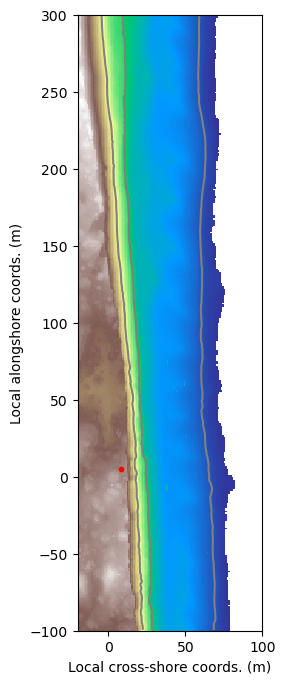

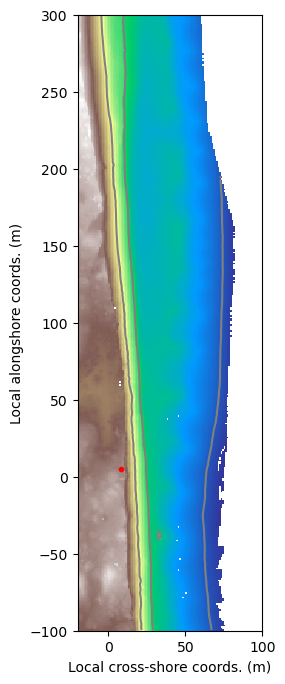

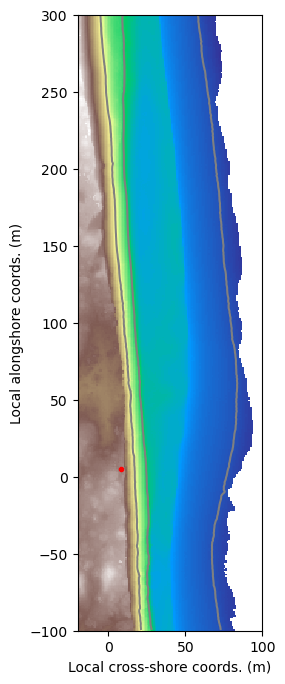

In [3]:
for fn in fn_list:
    ncfn = fn.replace(".tif","_local_coords.nc")
    # Read it in and check plot
    dsr = xr.open_dataset( data_dir+ncfn )
    # Contour elevations
    levels = [-10 -5, 0, 5, 10 ]
    fig, axes = plt.subplots(1, 1, figsize = (5, 8) )
    plt.pcolormesh( dsr['localX'], dsr['localY'], dsr['Zi'], cmap='terrain' )
    plt.contour(  dsr['localX'], ds['localY'], dsr['Zi'], levels=levels, colors='gray' )
    plt.plot(cx, cy, '.r' )
    plt.xlabel('Local cross-shore coords. (m)')
    plt.ylabel('Local alongshore coords. (m)')
    axes.set_aspect( 'equal' )